In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import Data
data_exp = pd.read_csv("A4 Set B - Combined Datasheet.csv")
data_ver = pd.read_csv("csv-export.csv")

In [3]:
print(data_exp.columns)
Elements = ["Hydrogen", "Nitrogen", "Helium", "Neon"]

Index(['Element', 'Spectral line Rank', 'theta_left', 'theta_right', 'd_theta',
       'Order', 'lambda_left', 'lambda_right'],
      dtype='object')


In [4]:
# sns.pairplot(data_ver)

## Experimental Data Analysis

In [5]:
print(data_exp.columns)

Index(['Element', 'Spectral line Rank', 'theta_left', 'theta_right', 'd_theta',
       'Order', 'lambda_left', 'lambda_right'],
      dtype='object')


In [6]:
# Calculate Uncertainty
data_exp["lambda_unc"] = np.sin(data_exp["d_theta"]*np.pi/180)*((1/100)*(1/1000))*(1000000000)
data_exp["mean_lambda"] = (data_exp["lambda_left"] + data_exp["lambda_right"])/2

In [7]:
# print(data_exp["lambda_unc"])

In [8]:
# filtered_df = df[(df['element'] == 'Hydrogen') & (df['order'] == 1)]

f_exp_by_elements = {}
for E in ["Hydrogen", "Nitrogen", "Helium", "Neon"]:
    f_exp_by_elements[f"{E}"] = data_exp[(data_exp["Element"] == E) & (data_exp["Order"] == 1)]

In [9]:
print(f_exp_by_elements["Neon"])

   Element  Spectral line Rank  theta_left  theta_right   d_theta  Order  \
23    Neon                   1    2.666667     2.833333  0.166667      1   
24    Neon                   2    2.833333     3.116667  0.283333      1   
25    Neon                   3    3.100000     3.250000  0.150000      1   
26    Neon                   4    3.216667     3.600000  0.383333      1   
27    Neon                   5    3.416667     3.666667  0.250000      1   
28    Neon                   6    3.583333     3.833333  0.250000      1   
29    Neon                   7    3.666667     4.050000  0.383333      1   

    lambda_left  lambda_right  lambda_unc  mean_lambda  
23   465.253122    494.308433   29.088780   479.780778  
24   494.308433    543.692732   49.450794   519.000583  
25   540.788130    566.927876   26.179909   553.858003  
26   561.119373    627.905195   66.903789   594.512284  
27   595.967473    639.517336   43.633093   617.742404  
28   625.002027    668.543865   43.633093   646.7

## Vernier Data Analysis

In [10]:
# Plotting Stuff
def plot_spectral(x, y, element):
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(12, 6))

    sns.lineplot(
        x=x, 
        y=y, 
        label=f"{element} Spectrum", 
        color="blue",
        linewidth=2.5
    )
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Intensity", fontsize=14)
    plt.title(f"{element} Spectral Line Data", fontsize=16, fontweight="bold")

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.legend(fontsize=12)

    plt.show()
    
def remove_noise(noise_intensity, noise_wavelength, element_intensity, element_wavelength, element):

    element_df = pd.DataFrame({'Wavelength': element_wavelength, f'{element}_Intensity': element_intensity})
    noise_df = pd.DataFrame({'Wavelength': noise_wavelength, 'Noise_Intensity': noise_intensity})

    merged_df = pd.merge(element_df, noise_df, on='Wavelength', how='left').fillna(0)

    merged_df['Corrected_Intensity'] = merged_df[f'{element}_Intensity'] - merged_df['Noise_Intensity']

    merged_df['Corrected_Intensity'] = np.maximum(merged_df['Corrected_Intensity'], 0)

    return merged_df[['Wavelength', 'Corrected_Intensity']]


In [11]:
# data_ver
# Remove Absorbance
cols_to_drop = [col for col in data_ver.columns if "Absorbance" in col]

# Drop the columns from the DataFrame
data_ver_cleaned = data_ver.drop(columns=cols_to_drop)
print(data_ver_cleaned.columns)

Index(['Hydrogen:Wavelength(nm)', 'Hydrogen:Raw', 'Noise:Wavelength(nm)',
       'Noise:Raw', 'Nitrogen:Wavelength(nm)', 'Nitrogen:Raw',
       'Helium:Wavelength(nm)', 'Helium:Raw', 'Mercury:Wavelength(nm)',
       'Mercury:Raw', 'Neon:Wavelength(nm)', 'Neon:Raw', 'CO2:Wavelength(nm)',
       'CO2:Raw', 'Data Set 8:Wavelength(nm)', 'Data Set 8:Raw'],
      dtype='object')


In [12]:
# Clean Elements by Clipping
Elements = ["Hydrogen", "Nitrogen", "Helium", "Neon"]
cleaned_elements = {}
for E in Elements:
    cleaned_elements[f"{E}"] = remove_noise(data_ver_cleaned["Noise:Raw"], data_ver_cleaned["Noise:Wavelength(nm)"], data_ver_cleaned[f"{E}:Raw"], data_ver_cleaned[f"{E}:Wavelength(nm)"], E)

In [13]:
# Clean Elements by gaussian filter
from scipy.ndimage import gaussian_filter1d

def remove_noise_g(data, column, sigma=1):

    df = data.copy()

    df[column] = gaussian_filter1d(df[column], sigma=sigma)
    
    return df

In [14]:
Vernier_Data = {}
for E in Elements:
    Vernier_Data[f"{E}"] = remove_noise_g(cleaned_elements[f"{E}"], "Corrected_Intensity", 10)

In [15]:
print(Vernier_Data["Hydrogen"])

     Wavelength  Corrected_Intensity
0         380.6            24.586381
1         381.4            24.657194
2         382.3            24.797415
3         383.2            25.005179
4         384.0            25.276892
..          ...                  ...
639       896.5             0.145040
640       897.4             0.136980
641       898.2             0.130773
642       899.1             0.126556
643       900.0             0.124419

[644 rows x 2 columns]


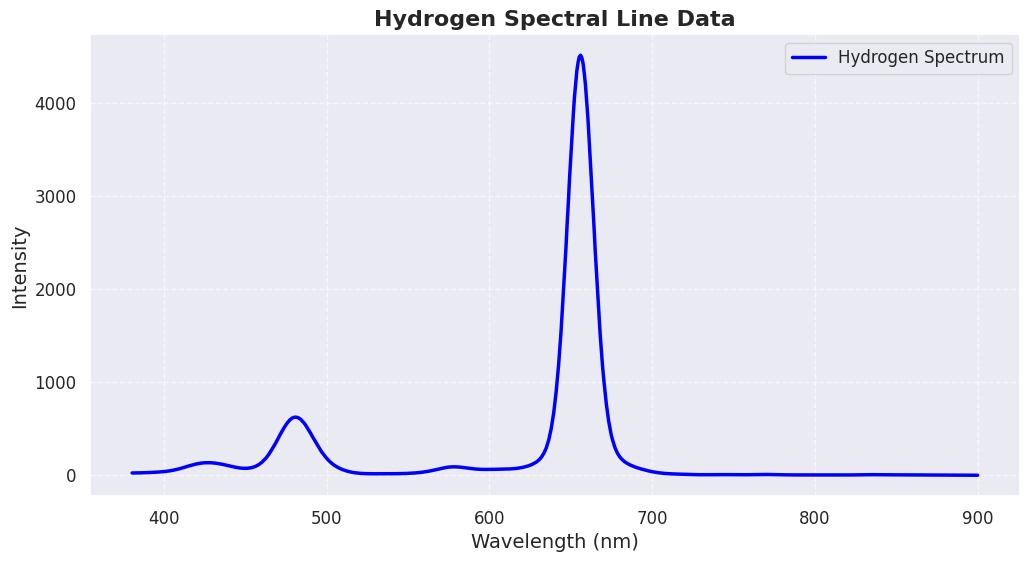

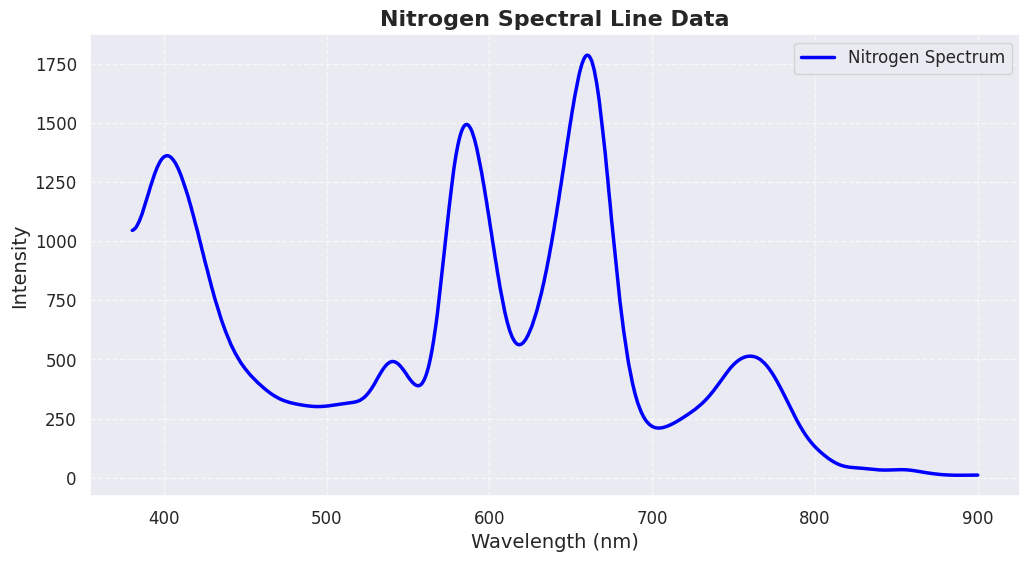

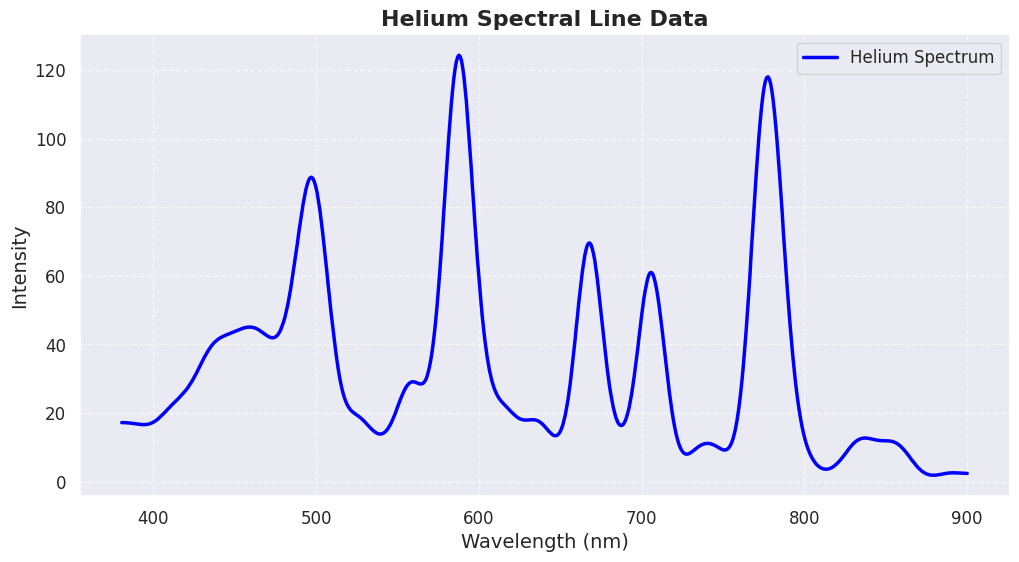

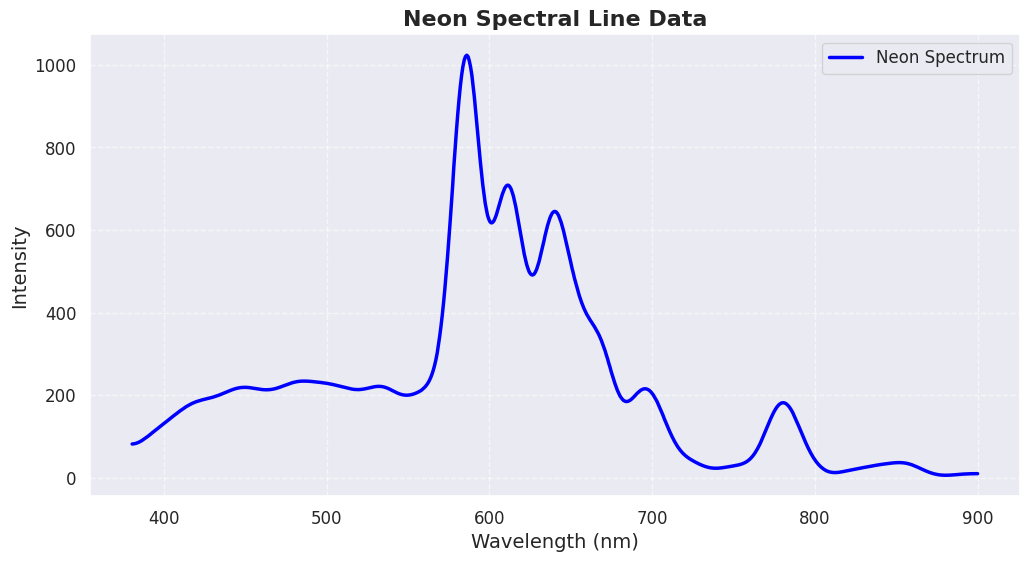

In [16]:
# Plot Spectral lines
for E in Elements:
    plot_spectral(Vernier_Data[f"{E}"]["Wavelength"], Vernier_Data[f"{E}"]["Corrected_Intensity"], E)

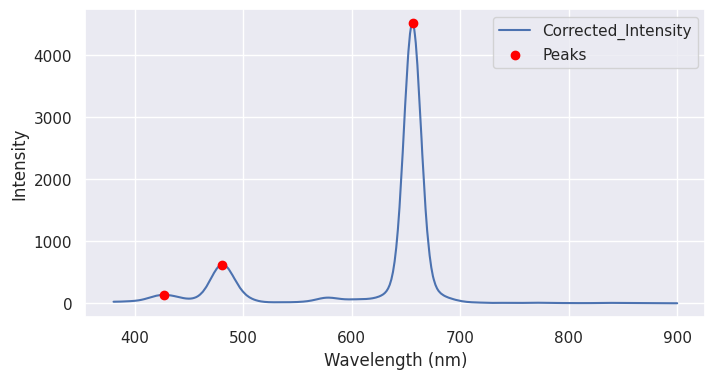

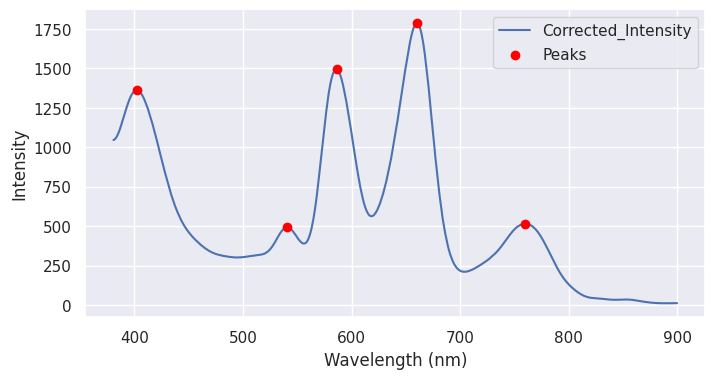

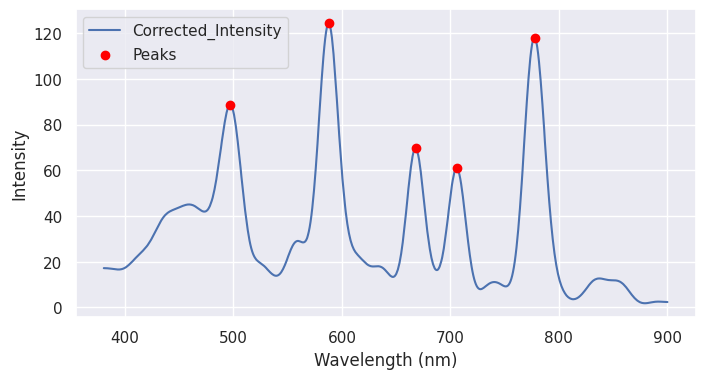

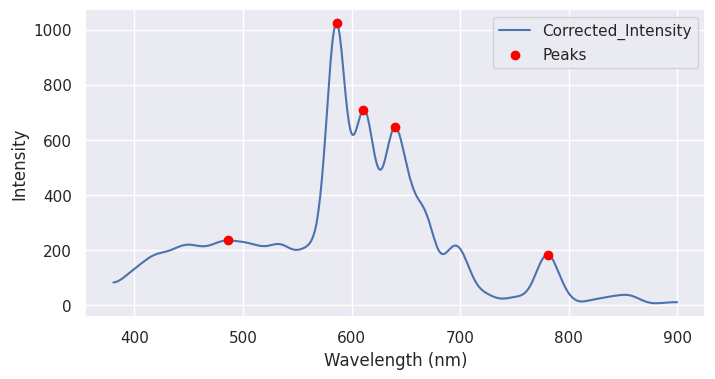

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def get_local_peaks(data, column, prominence=0.1, distance=5):

    df = data.copy()
    peaks, _ = find_peaks(df[column], prominence=prominence, distance=distance)

    df["Peaks"] = 0
    df.loc[peaks, "Peaks"] = 1  # Mark peaks in the DataFrame

    return df, peaks

for E in Elements:
    clean_df, peak_indices = get_local_peaks(Vernier_Data[f"{E}"], column="Corrected_Intensity", prominence=34, distance=5)

    # Plot results
    plt.figure(figsize=(8, 4))
    plt.plot(clean_df["Wavelength"], clean_df["Corrected_Intensity"], label="Corrected_Intensity")
    plt.scatter(clean_df["Wavelength"].iloc[peak_indices], clean_df["Corrected_Intensity"].iloc[peak_indices], 
                color='red', label="Peaks", zorder=3)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    plt.legend()
    plt.show()


In [18]:
# # Plot Spectral lines
# for E in Elements:
#     find_and_plot_peaks(bands[f"{E[0]}"], cleaned_elements[f"{E}"]["Wavelength"], cleaned_elements[f"{E}"]["Corrected_Intensity"], E, f_exp_by_elements[f"{E}"]["mean_lambda"], f_exp_by_elements[f"{E}"]["lambda_unc"])

## Retrieve Data from NIST

In [19]:
import requests
from bs4 import BeautifulSoup
import io
# site = "https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra={}" \
#                "&limits_type=0&low_w={}" \
#                "&upp_w={}" \
#                "&unit=1&submit=Retrieve+Data&de=0&format=3&line_out=0&remove_js=on&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=2&max_upp_enrg=&tsb_value=0&min_str=&A_out=1&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on"

In [20]:
# Load all Data
NIST_data = {}
for element in ["He", "H", "N", "Ne"]:
    site = "https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra={}" \
               "&limits_type=0&low_w={}" \
               "&upp_w={}" \
               "&unit=1&submit=Retrieve+Data&de=0&format=3&line_out=0&remove_js=on&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=2&max_upp_enrg=&tsb_value=0&min_str=&A_out=1&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on"
    site = site.format(element, 200, 780)
    respond = requests.get(site)
    soup = BeautifulSoup(respond.content, 'lxml')
    html_data = soup.get_text()
    html_data = html_data.replace('"', "")
    data = io.StringIO(html_data)
    NIST_data[f"{element}"] = pd.read_csv(data, sep="\t")

In [61]:
import re

def clean_intensity(value):
    if isinstance(value, str):  
        # Extract the first valid number (including decimals)
        match = re.search(r'\d+(\.\d+)?', value)
        if match:
            value = match.group(0)  # Get the matched number
        else:
            return None  # Return None if no number is found
    return pd.to_numeric(value, errors='coerce')  # Convert to number, NaN if invalid

for element in ["H", "He", "N", "Ne"]:
    NIST_data[f"{element}"] = NIST_data[f"{element}"].dropna(subset=['obs_wl_air(nm)'])
    NIST_data[f"{element}"] = NIST_data[f"{element}"].dropna(subset=['intens'])
    NIST_data[f"{element}"]["intens"] = NIST_data[f"{element}"]["intens"].apply(clean_intensity)
    if element in ["N", "Ne"]:
        if element == "Ne":
            NIST_data[f"{element}"] = NIST_data[f"{element}"][(NIST_data[f"{element}"]["intens"] < 20000)]
        unique_sp_nums = NIST_data[f"{element}"]["sp_num"].unique()
        print(unique_sp_nums)
        for sp in unique_sp_nums:
            NIST_data[f"{element}_{sp}"] = NIST_data[f"{element}"][(NIST_data[f"{element}"]["sp_num"] == sp)]

[3 4 2 5 1]
[5 3 2 8 4 6 7 1]


In [62]:
# NIST_data

In [63]:
# # Find Theo
# def find_theo(df_exp, df_theo):
#     df_exp["theo_lambda"] = df_exp["mean_lambda"].apply(lambda x: df_theo.iloc[(df_theo["obs_wl_air(nm)"] - x).abs().argmin()]['obs_wl_air(nm)'])

# small_Elements = ["H", "N", "He", "Ne"]
# for i, element in enumerate(["Hydrogen", "Nitrogen", "Helium", "Neon"]):
#     find_theo(f_exp_by_elements[f"{element}"], NIST_data[f"{small_Elements[i]}"])
    

In [64]:
# f_exp_by_elements["Hydrogen"]

In [65]:
# f_exp_by_elements["Nitrogen"]

In [66]:
# f_exp_by_elements["Helium"]

In [67]:
# f_exp_by_elements["Neon"]

In [68]:
# # Find Error 
# for elements in ["Hydrogen", "Nitrogen", "Helium", "Neon"]:
#     f_exp_by_elements[f"{elements}"]["Error (%)"] = 100*np.abs(f_exp_by_elements[f"{elements}"]["mean_lambda"] - f_exp_by_elements[f"{elements}"]["theo_lambda"])/f_exp_by_elements[f"{elements}"]["theo_lambda"]

In [69]:
bands = {}

In [70]:
f_exp_by_elements["Hydrogen"]
bands["Hydrogen"] = []

In [71]:
f_exp_by_elements["Nitrogen"]
bands["Nitrogen"] = [17, 18, 19 , 22]

In [72]:
f_exp_by_elements["Helium"]
bands["Helium"] = [9, 10, 11, 12]

In [73]:
f_exp_by_elements["Neon"]
bands["Neon"] = [25, 26, 27]

In [74]:
# # Theoretical Number of Spectral Lines vs Experimental
# for elements in Elements:
#     print(f"{elements}")
#     print(f" Theoretical {f_exp_by_elements[f"{elements}"]["theo_lambda"].nunique()}, Experimental {len(f_exp_by_elements[f"{elements}"]["Spectral line Rank"])}")

In [75]:
def wavelength_to_rgb(wavelength, intensity=1.0):
    """
    Convert a wavelength in nm to an approximate RGB color with intensity adjustment.
    
    Parameters:
    - wavelength (float): Wavelength in nm (380-780).
    - intensity (float): Intensity value (0 to 1), where 0 is black and 1 is full color.
    
    Returns:
    - tuple: (R, G, B) values scaled from 0 to 1.
    """
    gamma = 0.8
    intensity = np.clip(intensity, 0, 1)  # Ensure intensity is between 0 and 1
    R = G = B = 0

    if 380 <= wavelength < 440:
        R = -(wavelength - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif 440 <= wavelength < 490:
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif 490 <= wavelength < 510:
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif 510 <= wavelength < 580:
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif 580 <= wavelength < 645:
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif 645 <= wavelength < 780:
        R = 1.0
        G = 0.0
        B = 0.0

    # Apply gamma correction and scale by intensity
    R = ((R * intensity) ** gamma)
    G = ((G * intensity) ** gamma)
    B = ((B * intensity) ** gamma)

    return (R, G, B)

def normalize_intensities(intensities):
    """
    Normalize intensity values to [0,1] and set values below 50% to 0.
    
    Parameters:
    - intensities (array-like): List/array of intensity values.
    
    Returns:
    - array: Normalized intensities with values below 50% set to 0.
    """
    min_intensity = np.min(intensities)
    max_intensity = np.max(intensities)
    if max_intensity == min_intensity:  # Avoid division by zero
        return np.ones_like(intensities)
    
    normalized = (intensities - min_intensity) / (max_intensity - min_intensity)
#     normalized[normalized < 0.99] = 0  # Set values below 50% to 0
    return normalized

def plot_spectral_lines(wavelengths, intensities=None, title = None):
    """
    Plot spectral emission lines for given wavelengths with optional intensity values.
    
    Parameters:
    - wavelengths (list or np.array): List of wavelengths (in nm).
    - intensities (list or np.array, optional): Corresponding intensity values (0 to 1).
    """
    wavelengths = np.array(wavelengths)  # Convert to numpy array
    
    if intensities is None:
        intensities = np.ones_like(wavelengths)  # Default to full brightness
    else:
#         intensities = np.array(intensities)
        intensities = normalize_intensities(intensities)
#         plt.plot(intensities, label = title)
#         plt.legend()

    fig, ax = plt.subplots(figsize=(15, 2))
    
    ax.set_xlim(380, 780)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(400, 800, 50))
    ax.set_yticks([])  # Hide y-axis
#     print(intensities)
    for wavelength, intensity in zip(wavelengths, intensities):
        if 380 <= wavelength <= 780:
            color = wavelength_to_rgb(wavelength, intensity)
            ax.axvline(wavelength, color=color, linewidth=2)

    ax.set_facecolor('black')  # Background color
    ax.grid(False)
    ax.set_title(title, fontsize=14, pad=10)
#     plt.title("")
    plt.show()



<Figure size 640x480 with 0 Axes>

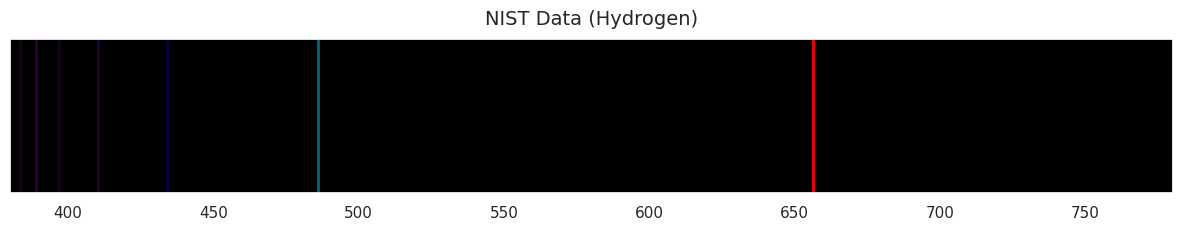

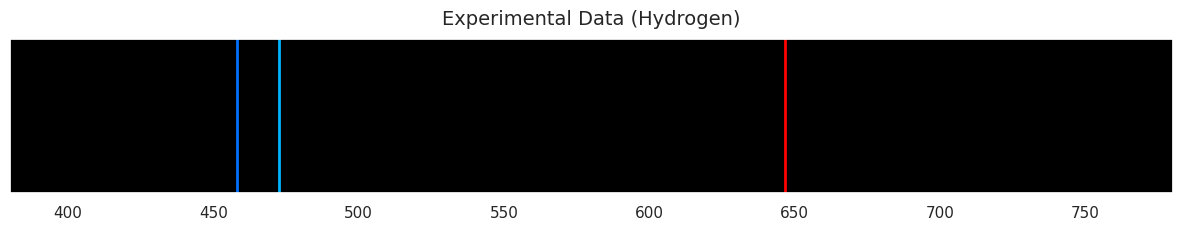

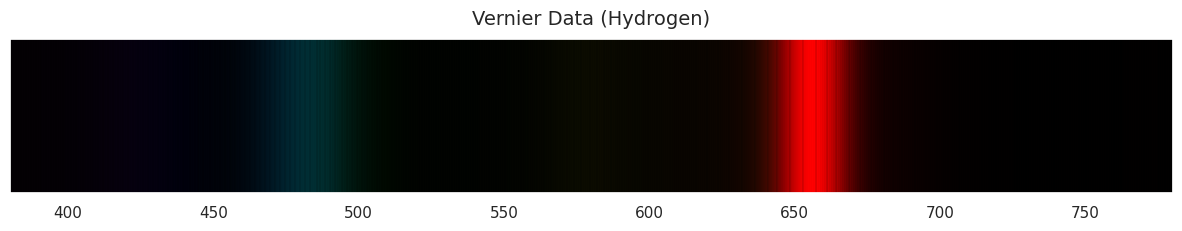

<Figure size 640x480 with 0 Axes>

In [82]:
plot_spectral_lines(NIST_data["H"]["obs_wl_air(nm)"], NIST_data["H"]["intens"], title = "NIST Data (Hydrogen)")  # Hydrogen spectral lines
plot_spectral_lines(f_exp_by_elements["Hydrogen"]["mean_lambda"], title = "Experimental Data (Hydrogen)") 
plot_spectral_lines(Vernier_Data["Hydrogen"]["Wavelength"], Vernier_Data[f"Hydrogen"]["Corrected_Intensity"], title = "Vernier Data (Hydrogen)")

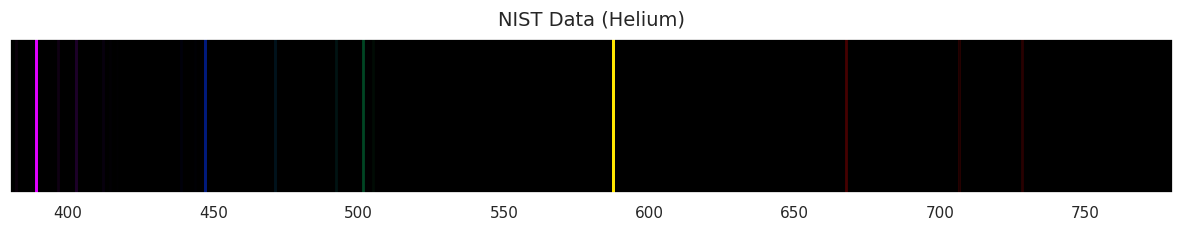

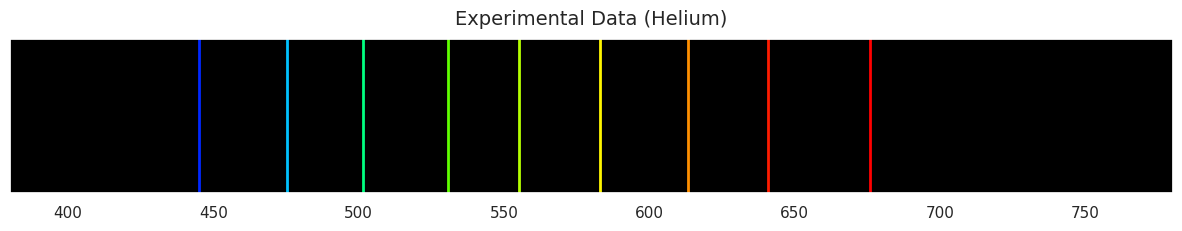

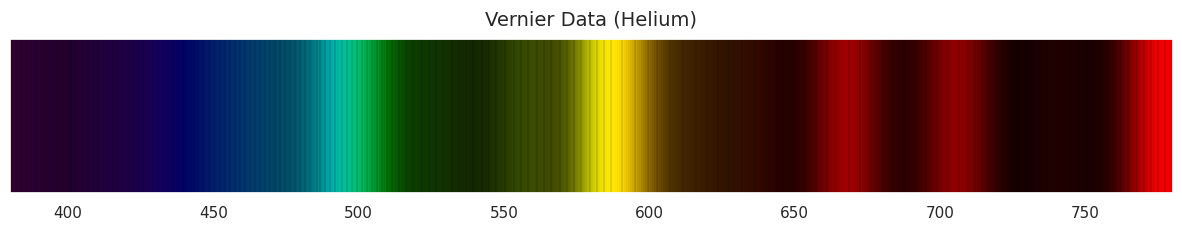

In [77]:
e = "Helium"
plot_spectral_lines(NIST_data["He"]["obs_wl_air(nm)"], NIST_data["He"]["intens"], title = f"NIST Data ({e})")  # Hydrogen spectral lines
plot_spectral_lines(f_exp_by_elements[f"{e}"]["mean_lambda"], title = f"Experimental Data ({e})") 
plot_spectral_lines(Vernier_Data[f"{e}"]["Wavelength"], Vernier_Data[f"{e}"]["Corrected_Intensity"], title =f"Vernier Data ({e})")

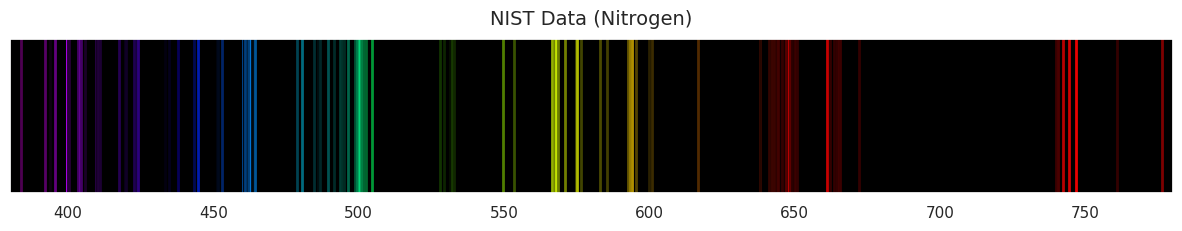

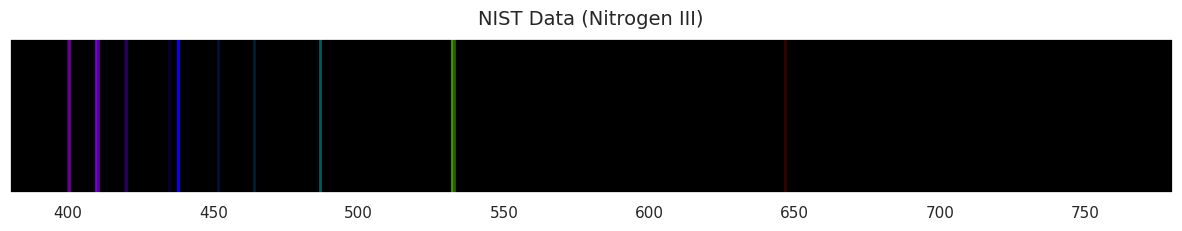

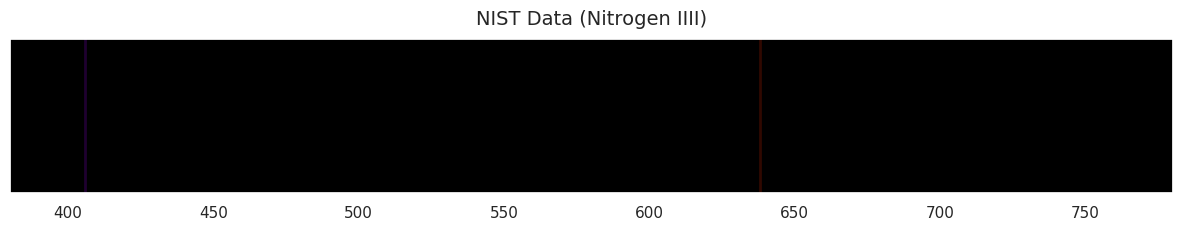

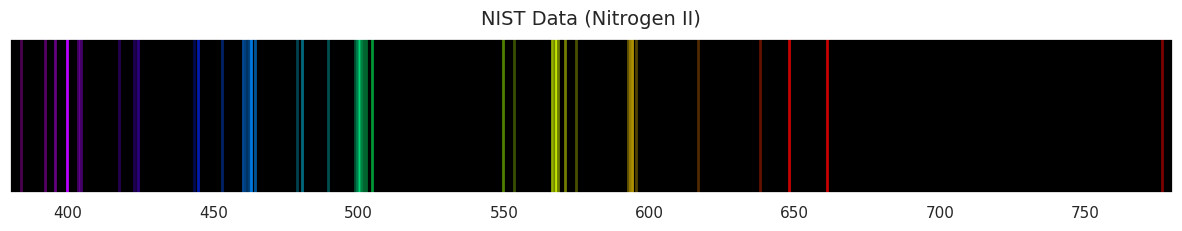

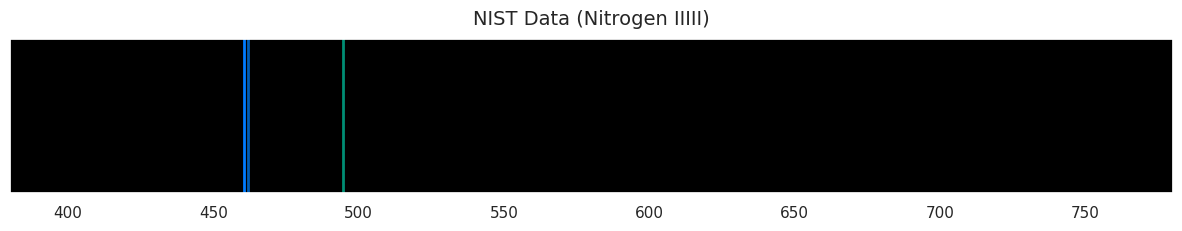

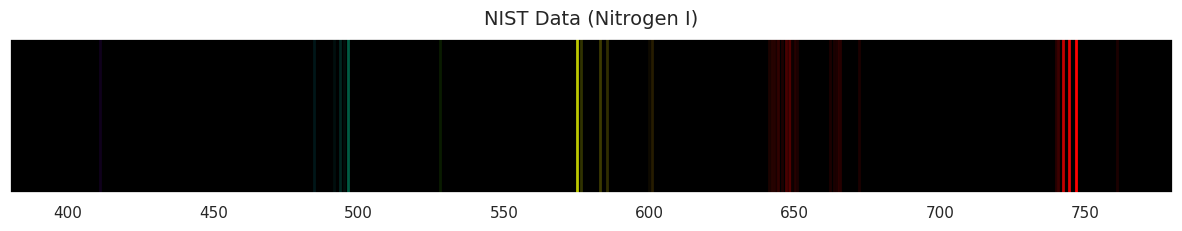

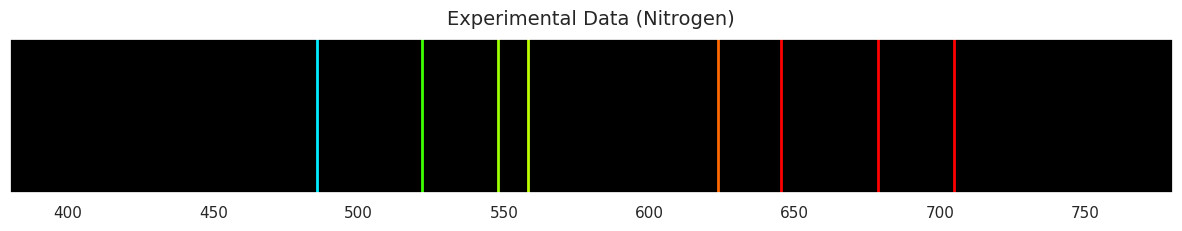

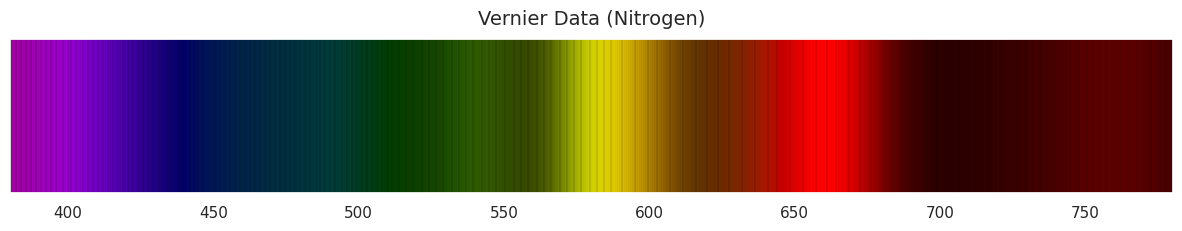

In [78]:
e = "Nitrogen"
# Plot NIST
# Total
plot_spectral_lines(NIST_data[f"N"]["obs_wl_air(nm)"],NIST_data[f"N"]["intens"], title = f"NIST Data ({e})")
unique_sp_nums = NIST_data[f"N"]["sp_num"].unique()
for sp in unique_sp_nums:
    plot_spectral_lines(NIST_data[f"N_{sp}"]["obs_wl_air(nm)"],NIST_data[f"N_{sp}"]["intens"], title = f"NIST Data ({e} {sp*"I"})")  # Hydrogen spectral lines
plot_spectral_lines(f_exp_by_elements[f"{e}"]["mean_lambda"], title = f"Experimental Data ({e})") 
plot_spectral_lines(Vernier_Data[f"{e}"]["Wavelength"], Vernier_Data[f"{e}"]["Corrected_Intensity"], title =f"Vernier Data ({e})")

In [81]:
# plt.scatter([i for i in range(len(NIST_data["Ne"]["intens"]))], NIST_data["Ne"]["intens"])

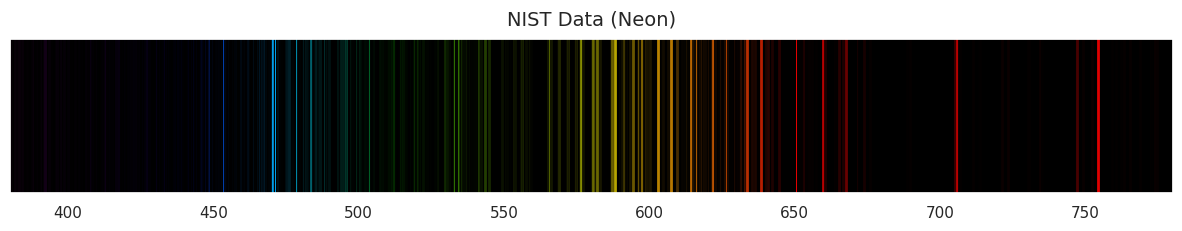

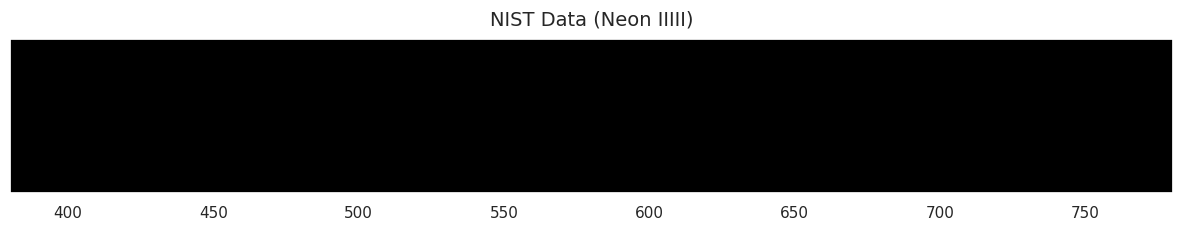

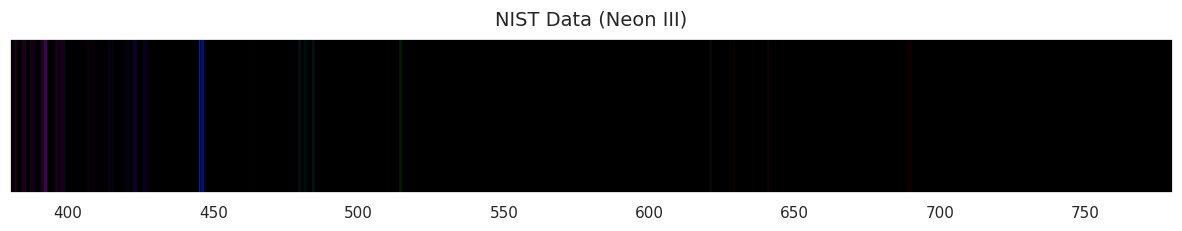

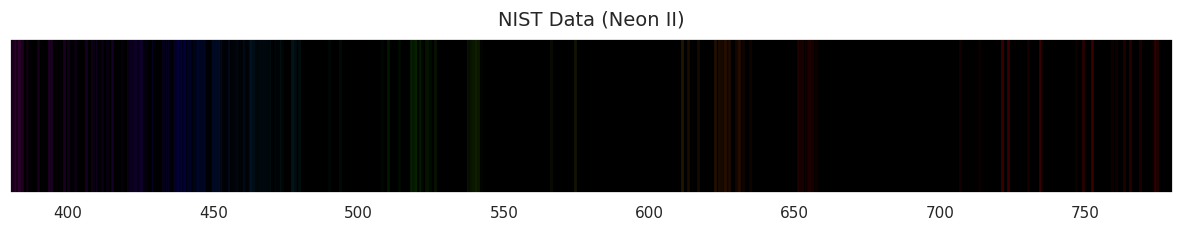

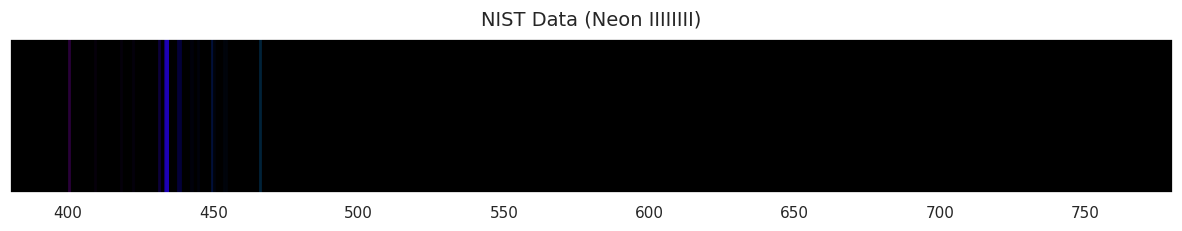

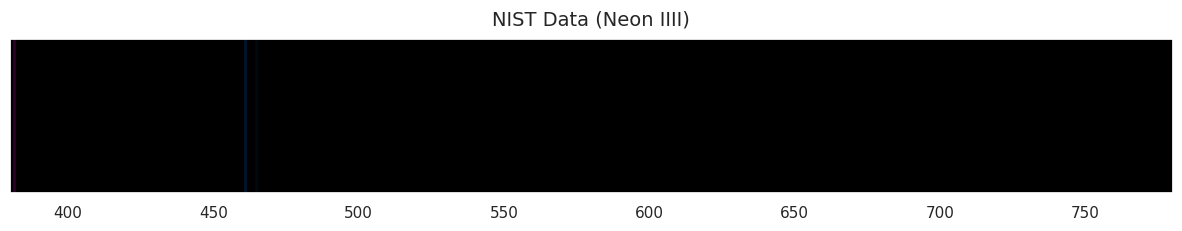

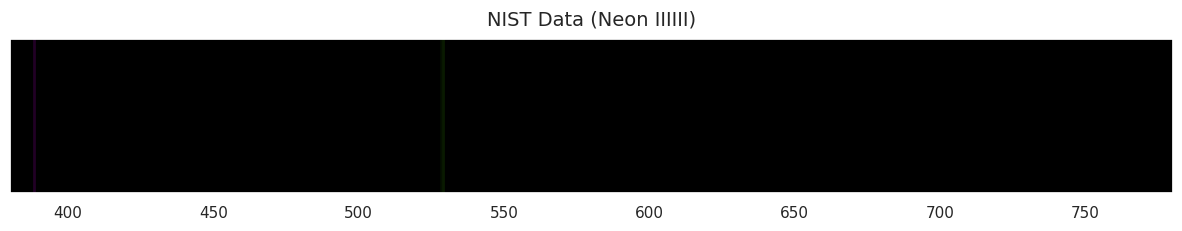

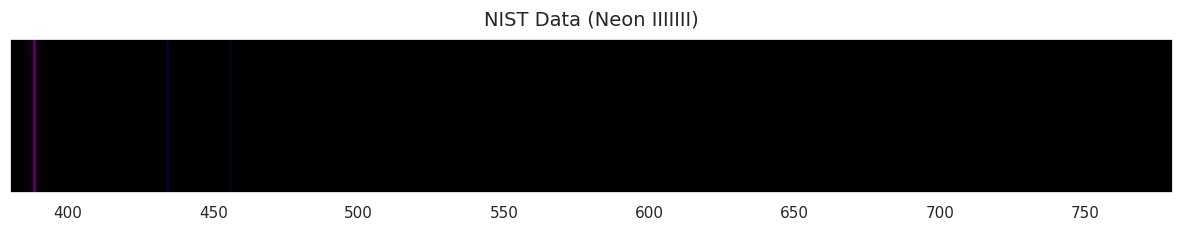

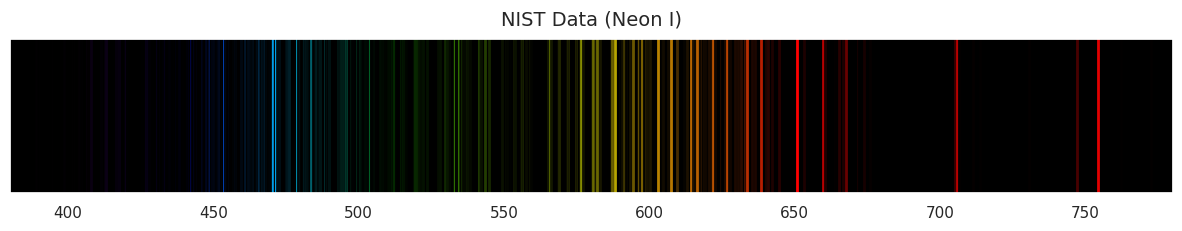

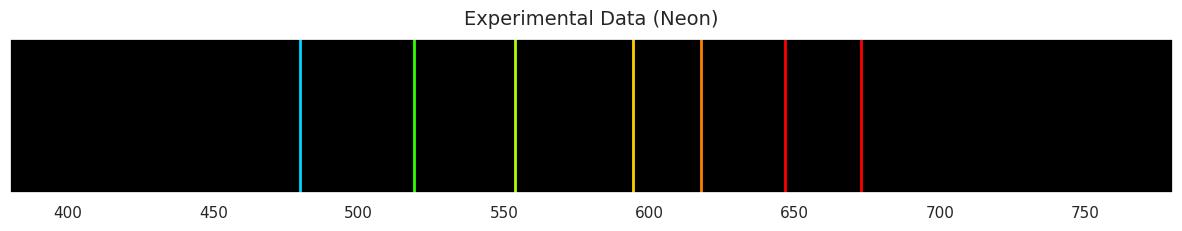

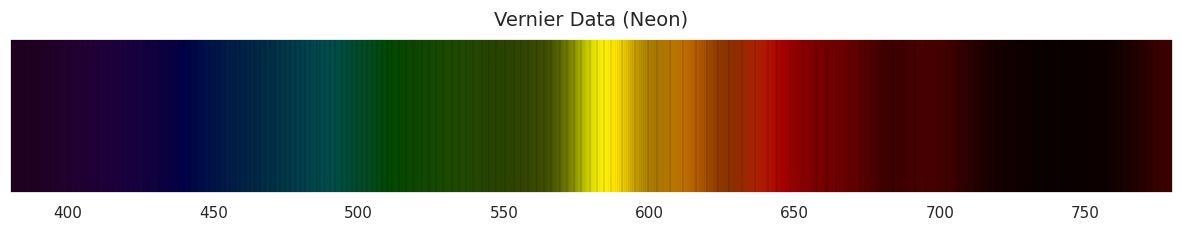

In [80]:
e = "Neon"

plot_spectral_lines(NIST_data[f"Ne"]["obs_wl_air(nm)"], NIST_data[f"Ne"]["intens"], title = f"NIST Data ({e})")
unique_sp_nums = NIST_data[f"Ne"]["sp_num"].unique()
for sp in unique_sp_nums:
    plot_spectral_lines(NIST_data[f"Ne_{sp}"]["obs_wl_air(nm)"], NIST_data[f"Ne_{sp}"]["intens"], title = f"NIST Data ({e} {sp*"I"})")  # Hydrogen spectral lines

# plot_spectral_lines(NIST_data["Ne_new"]["obs_wl_air(nm)"], NIST_data["Ne_new"]["intens"], title = f"NIST Data ({e})")  # Hydrogen spectral lines
plot_spectral_lines(f_exp_by_elements[f"{e}"]["mean_lambda"], title = f"Experimental Data ({e})") 
plot_spectral_lines(Vernier_Data[f"{e}"]["Wavelength"], Vernier_Data[f"{e}"]["Corrected_Intensity"], title =f"Vernier Data ({e})")